In [20]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
from sklearn.utils import class_weight
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
def load_data(datafile, flare_label, series_len, start_feature, n_features, mask_value):
    df=pd.read_csv(datafile)
    df_values=df.values
    X=[]
    y=[]
    tmp=[]
    for k in range (start_feature, start_feature+n_features):
        tmp.append(mask_value)
    for idx in range(0, len(df_values)):
        each_series_data=[]
        row=df_values[idx]
        if flare_label == 'M5' and row[1][0]=='M' and float(row[1][1:]) >=5.0:
            label='X'
        else:
            label=row[1][0]
        if flare_label=='M' and label=='X':
            label='M'
        if flare_label=='C' and (label=='X' or label=='M'):
            label='C'
        if flare_label=='B' and (label=='X' or label=='M' or label=='C'):
            label='B'
        if flare_label=='M5' and (label=='M' or label=='C' or label=='B'):
            label='N'
        if flare_label=='M' and (label=='B' or label=='C'):
            label='N'
        if flare_label=='C' and label=='B':
            label='N'
        has_zero_record=False
        #if at least one of the 25 physical feature values is missing, then discard it
        if flare_label=='C':
            if float(row[5])==0.0:
                has_zero_record=True
            if float(row[7])==0.0:
                has_zero_record=True
            for k in range(9, 13):
                if float(row[k])==0.0:
                    has_zero_record=True
                    break
            for k in range(14, 16):
                if float(row[k])==0.0:
                    has_zero_record=True
                    break
            for k in range(18, 21):
                if float(row[k])==0.0:
                    has_zero_record=True
                    break
            if float(row[22])==0.0:
                has_zero_record=True
            for k in range(24, 33):
                if float(row[k])==0.0:
                    has_zero_record=True
                    break
            for k in range(38, 42):
                if float(row[k])==0.0:
                    has_zero_record=True
                    break
            #check only for C flares prediction
            
            if has_zero_record is False:
                cur_noaa_num=int(row[3])
                each_series_data.append(row[start_feature:start_feature+n_features].tolist())
                itr_idx=idx-1
                while itr_idx>=0 and len(each_series_data)<series_len:
                    prev_row=df_values[itr_idx]
                    prev_noaa_num=int(prev_row[3])
                    if prev_noaa_num!=cur_noaa_num:
                        break
                    has_zero_record_tmp=False
                    if flare_label=='C':
                        if float(row[5])==0.0:
                            has_zero_record_tmp=True
                        if float(row[7])==0.0:
                            has_zero_record_tmp=True
                        for k in range(9, 13):
                            if float(row[k])==0.0:
                                has_zero_record_tmp=True
                                break
                        for k in range(14, 16):
                            if float(row[k])==0.0:
                                has_zero_record_tmp=True
                                break
                        for k in range(18, 21):
                            if float(row[k])==0.0:
                                has_zero_record_tmp=True
                                break
                        if float(row[22])==0.0:
                                has_zero_record_tmp=True
                        for k in range(24, 33):
                            if float(row[k])==0.0:
                                has_zero_record_tmp=True
                                break
                        for k in range(38, 42):
                            if float(row[k])==0.0:
                                has_zero_record_tmp=True
                                break
                                
                                #tested only for C flares
                    if len(each_series_data)<series_len and has_zero_record_tmp is True:
                        each_series_data.insert(0, tmp)
                    
                    if len(each_series_data)<series_len and has_zero_record_tmp is False:
                        each_series_data.insert(0, prev_row[start_feature:start_feature+n_features].tolist())
                    itr_idx-=1
                while len(each_series_data)>0 and len(each_series_data)<series_len:
                    each_series_data.insert(0, tmp)
                
                if len(each_series_data)>0:
                    X.append(np.array(each_series_data).reshape(series_len, n_features).tolist())
                    y.append(label)
    X_arr=np.array(X)
    y_arr=np.array(y)
    print(X_arr.shape)
    return X_arr, y_arr


                        
                

In [3]:
flare_label='C'
filepath='./'+flare_label+'/'
n_features=14
num_of_fold=10
start_feature=5
mask_value=0
series_len=10
epochs=7
batch_size=256
nclass=2
thlistsize=201
thlist=np.linspace(0, 1, thlistsize)

X_train_data, y_train_data = load_data(datafile=filepath+'normalized_training.csv', 
                                       flare_label=flare_label,
                                       series_len=series_len,
                                       start_feature=start_feature,
                                       n_features=n_features,
                                       mask_value=mask_value)

X_valid_data, y_valid_data=load_data(datafile=filepath+'normalized_validation.csv', 
                                     flare_label=flare_label,
                                     series_len=series_len,
                                     start_feature=start_feature,
                                     n_features=n_features,
                                     mask_value=mask_value)

X_test_data, y_test_data=load_data(datafile=filepath+'normalized_testing.csv',
                                   flare_label=flare_label,
                                   series_len=series_len,
                                   start_feature=start_feature,
                                   n_features=n_features,
                                   mask_value=mask_value)


(84577, 10, 14)
(26473, 10, 14)
(44689, 10, 14)


In [4]:
def partition_10_folds(X, y, num_of_fold):
    num=len(X)
    index=[i for i in range(num)]
    np.random.seed(123)
    np.random.shuffle(index)
    X_output=[]
    y_output=[]
    num_in_each_fold=round(num/num_of_fold)
    for i in range(num_of_fold):
        if i == (num_of_fold-1):
            idx=index[num_in_each_fold*(num_of_fold-1):]
        else:
            idx=index[num_in_each_fold*i:num_in_each_fold*(i+1)]
        X_output.append(X[idx])
        y_output.append(y[idx])
    return X_output, y_output

    

In [5]:
def data_transform(data):
    encoder=LabelEncoder()
    encoder.fit(data)
    encoded_Y=encoder.transform(data)
    print(encoded_Y)
    converteddata=F.one_hot(torch.Tensor(encoded_Y).long())
    return converteddata.float()
    

In [6]:
def data_transform_ce(data):
    encoder=LabelEncoder()
    encoder.fit(data)
    encoded_Y=encoder.transform(data)
    return encoded_Y

In [7]:
class RNNModel(nn.Module):
    
    def __init__(self, rnn_layer, vocab_size, **kwards):
        super(RNNModel, self).__init__(**kwards)
        self.rnn=rnn_layer
        self.vocab_size=vocab_size
        self.num_hiddens=self.rnn.hidden_size
        #If the RNN is bedirectional, 
        #'num_directions' should be 2 , else it shuld be 1.
        if not self.rnn.bidirectional:
            self.num_directions=1
            self.drop=nn.Dropout(0.5)
            self.linear=nn.Linear(self.num_hiddens, self.num_hiddens)
            self.linear1=nn.Linear(self.num_hiddens*2, self.num_hiddens, bias=False)
            self.linear2=nn.Linear(self.num_hiddens, 200)
            self.linear3=nn.Linear(200, 500)
            self.linear4=nn.Linear(500, 2)
        else:
            self.num_directions=2
            self.linear=nn.Linear(self.num_hiddens*2, self.vocab_size)
            
    def forward(self, inputs, state):
        #X=F.one_hot(inputs.T.long(), self.vocab_size)
        #X=X.to(torch.float32)
        inputs=inputs.permute(1, 0, 2)
        Y, state=self.rnn(inputs, state)
        #The fully connected layer will first change the shape of 'Y' to
        # ('num_steps'*'batch_size', 'num_hiddens'). Its output shape is
        #('num_steps'*'batch_size', 'vocab_size').
        h_t=Y[-1, :, :]
        Y=self.drop(Y)
        output=self.linear(Y)
        o=output.permute(1, 2, 0)
        h=h_t.unsqueeze(1)
        score=torch.bmm(h, o)
        s=score.squeeze(1)
        activation_weight=F.softmax(s, dim=1)
        o1=output.permute(1, 2, 0)
        s1=activation_weight.unsqueeze(2)
        context_vector=torch.bmm(o1, s1)
        context_vector=context_vector.squeeze(2)
        pre_activation=torch.cat((context_vector, h_t), dim=1)
        attention_vector=self.linear1(pre_activation)
        attention_vector=torch.tanh(attention_vector)
        layer1_out=self.linear2(attention_vector)
        layer1_out=F.relu(layer1_out)
        layer2_out=self.linear3(layer1_out)
        layer2_out=F.relu(layer2_out)
        model_output=self.linear4(layer2_out)
        model_output=F.softmax(model_output, dim=1)
        return state, model_output
    
    def begin_state(self, batch_size=1):
            #'nn.LSTM takes a tuple of hidden states'
            return (torch.zeros((self.num_directions*self.rnn.num_layers, batch_size, self.num_hiddens)), 
                    torch.zeros((self.num_directions*self.rnn.num_layers, batch_size, self.num_hiddens)))

In [8]:
def train_epoch_ch8(model, train_iter, train_exp,  updater, loss,  #@save
                    use_random_iter):
    """Train a model within one epoch (defined in Chapter 8)."""
    state= None
    #metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    count=0
    for X, Y in train_iter:
        if count!=train_exp:
            
            if state is None or use_random_iter:
                # Initialize `state` when either it is the first iteration or
                # using random sampling
                state = model.begin_state(batch_size=8457)
            else:
                if isinstance(model, nn.Module) and not isinstance(state, tuple):
                    # `state` is a tensor for `nn.GRU`
                    state.detach_()
                else:
                    # `state` is a tuple of tensors for `nn.LSTM` and
                    # for our custom scratch implementation 
                    for s in state:
                        s.detach_()
            #y = Y.T.reshape(-1)
           # X, y = X.to(device), y.to(device)
           
            state, output = model(X, state)
           
            l=loss(output, Y.long() )+torch.tensor(1.0/8457)*torch.tensor(0.0001)*torch.sum(output**2)
            #l=torch.tensor(1/845)*(-torch.sum(class_weights*y*torch.log(output)+output**2))
            #l = loss(y_hat, y.long()).mean()
            if isinstance(updater, torch.optim.Optimizer):
                updater.zero_grad()
                l.backward()
                #grad_clipping(model, 1)
                updater.step()
        count+=1
            #metric.add(l * d2l.size(y), d2l.size(y))
    return l

In [9]:
def train_ch8(model, train_iter, train_exp, class_weights, lr, num_epochs, 
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""

    loss=nn.CrossEntropyLoss(weight=class_weights)
    # Initialize
    optim=torch.optim.Adam(model.parameters(), lr , betas = (0.9, 0.999))
    # Train and predict
    for epoch in range(num_epochs):
        l = train_epoch_ch8(
            model, train_iter,train_exp,  optim,loss, use_random_iter)
        print(f'loss {l:.4f}')

In [10]:
lr=0.001
tensor_x = torch.Tensor(X_train_data)
tensor_y = torch.Tensor(data_transform_ce(y_train_data))
train_dataset=TensorDataset(tensor_x, tensor_y)
train_dataloader=DataLoader(train_dataset, batch_size=8457, shuffle=True, drop_last=True)
m=10
num_epochs=40

In [11]:
class_weights_all={0:[], 1:[]}

In [12]:
for X, Y in train_dataloader:
    class_weights=class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(Y) , y=np.array(Y))
    class_weights_all[0].append(class_weights[0])
    class_weights_all[1].append(class_weights[1])

In [13]:
tensor_x_ts=torch.Tensor(X_test_data)
tensor_y_ts=torch.Tensor(data_transform_ce(y_test_data))
test_dataset=TensorDataset(tensor_x_ts, tensor_y_ts)
test_dataloader=DataLoader(test_dataset, batch_size=4468,  shuffle=True, drop_last=True)

In [14]:
thlistsize = 201
thlist = np.linspace(0, 1, thlistsize)

max_recall0=np.zeros(thlistsize)
max_precision0=np.zeros(thlistsize)
max_recall1=np.zeros(thlistsize)
max_precision1=np.zeros(thlistsize)
max_acc=np.zeros(thlistsize)
max_tss=np.zeros(thlistsize)
max_bacc=np.zeros(thlistsize)
max_hss=np.zeros(thlistsize)
recall0list=[]
recall1list=[]
precision0list=[]
precision1list=[]
acclist=[]
hsslist=[]
tsslist=[]
bacclist=[]
for ithlistsize in range(thlistsize):
    recall0list.append([])
    recall1list.append([])
    precision0list.append([])
    precision1list.append([])
    acclist.append([])
    hsslist.append([])
    tsslist.append([])
    bacclist.append([])
fraction_of_positives_list=[]
mean_predicted_value_list=[]
fpr_list=[]
tpr_list=[]
num_of_folds=10


In [15]:
for train_itr in range(num_of_folds):
        print('--------- '+str(train_itr) + ' iteration-------------')
        
        test_itr=train_itr
        classweights0=(np.sum(class_weights_all[0])-class_weights_all[0][train_itr])/num_of_folds
        classweights1=(np.sum(class_weights_all[1])-class_weights_all[1][train_itr])/num_of_folds
        classweights=np.array([classweights0, classweights1])
        classweights=torch.Tensor(classweights)
        
        lstm_layer=nn.LSTM(n_features, m)
        model=RNNModel(lstm_layer, m)
        
        train_ch8(model, train_dataloader, train_itr, classweights, lr, num_epochs)
        
        y_ts_all=torch.tensor([])
        output_ts_all=torch.tensor([])
        
        count=0
        for i in test_dataloader:
            if count!=test_itr:
                x, y=i
                output=model(x, model.begin_state(x.shape[0]))
                y_ts_all=torch.cat((y, y_ts_all))
                output_ts_all=torch.cat((output[1],output_ts_all), dim=0)
            count+=1
        loss=nn.CrossEntropyLoss(classweights)
        l=loss(output[1], y.long() )+torch.tensor(1.0/x.shape[0])*torch.tensor(0.0001)*torch.sum(output[1]**2)
        print('test loss: ' + str(l)+ '\n')
        
        
        for th in range(len(thlist)):
            idx = th
            thresh=thlist[idx]
            cmat=confusion_matrix(y_ts_all, np.array([output_ts_all[i][0]<(thresh) for i in range (output_ts_all.shape[0])]))
            N=np.sum(cmat)
            if th==100:
                print (thresh)
                print(cmat)
            if train_itr==4:
                tpr=float(cmat[1][1])/float(cmat[1][1]+cmat[1][0])
                fpr=float(cmat[0][1])/float(cmat[0][1]+cmat[0][0])
                tpr_list.append(tpr)
                fpr_list.append(fpr)
                
            recall=np.zeros(nclass)
            precision=np.zeros(nclass)
            accuracy=np.zeros(nclass)
            bacc=np.zeros(nclass)
            tss=np.zeros(nclass)
            hss=np.zeros(nclass)
            tp=np.zeros(nclass)
            fn=np.zeros(nclass)
            fp=np.zeros(nclass)
            tn=np.zeros(nclass)
            
            for p in range(nclass):
                tp[p]=cmat[p][p]
                for q in range(nclass):
                    if q!=p:
                        fn[p]+=cmat[p][q]
                        fp[p]+=cmat[q][p]
                tn[p]=N-tp[p]-fn[p]-fp[p]
                
                recall[p]=round(float(tp[p])/float(tp[p]+fn[p]+1e-6), 3)
                precision[p]=round(float(tp[p])/float(tp[p]+fp[p]+1e-6), 3)
                accuracy[p]=round(float(tp[p]+tn[p])/float(N), 3)
                bacc[p]=round(0.5*(float(tp[p])/float(tp[p]+fn[p])+float(tn[p])/float(tn[p]+fp[p])), 3)
                hss[p]=round(2*float(tp[p]*tn[p]-fp[p]*fn[p])/float((tp[p]+fn[p])*(fn[p]+tn[p])+(tp[p]+fp[p])*(fp[p]+tn[p])), 3)
                tss[p]=round(float(tp[p])/float(tp[p]+fn[p]+1e-6)-float(fp[p])/float(fp[p]+tn[p]+1e-6), 3)
                
            if tss[0] > max_tss[idx]:
                max_tss[idx]=tss[0]
                max_bacc[idx]=bacc[0]
                max_hss[idx]=hss[0]
                max_recall0[idx]=recall[0]
                max_precision0[idx]=precision[0]
                max_recall1[idx]=recall[1]
                max_precision1[idx]=precision[1]
                max_acc[idx]=accuracy[0]
                
            recall0list[idx].append(recall[0])
            recall1list[idx].append(recall[1])
            precision0list[idx].append(precision[0])
            precision1list[idx].append(precision[1])
            acclist[idx].append(accuracy[0])
            bacclist[idx].append(bacc[0])
            tsslist[idx].append(tss[0])
            hsslist[idx].append(hss[0])
            
        
                    
                    
                        
    

--------- 0 iteration-------------
loss 0.6487
loss 0.5779
loss 0.5767
loss 0.5759
loss 0.5598
loss 0.5695
loss 0.5640
loss 0.5630
loss 0.5566
loss 0.5498
loss 0.5527
loss 0.5469
loss 0.5453
loss 0.5532
loss 0.5421
loss 0.5465
loss 0.5385
loss 0.5306
loss 0.5386
loss 0.5377
loss 0.5408
loss 0.5237
loss 0.5262
loss 0.5302
loss 0.5243
loss 0.5344
loss 0.5334
loss 0.5321
loss 0.5302
loss 0.5258
loss 0.5274
loss 0.5296
loss 0.5236
loss 0.5329
loss 0.5163
loss 0.5142
loss 0.5255
loss 0.5266
loss 0.5269
loss 0.5184
test loss: tensor(0.5083, grad_fn=<AddBackward0>)

0.5
[[ 5829  1986]
 [ 5006 27391]]
--------- 1 iteration-------------
loss 0.6614
loss 0.5969
loss 0.5828
loss 0.5635
loss 0.5717
loss 0.5657
loss 0.5599
loss 0.5621
loss 0.5621
loss 0.5634
loss 0.5584
loss 0.5513
loss 0.5542
loss 0.5575
loss 0.5596
loss 0.5470
loss 0.5444
loss 0.5327
loss 0.5359
loss 0.5347
loss 0.5375
loss 0.5351
loss 0.5369
loss 0.5321
loss 0.5334
loss 0.5350
loss 0.5214
loss 0.5307
loss 0.5263
loss 0.5282
loss

In [16]:
avg_recall0_list = []
std_recall0_list = []
avg_precision0_list = []
std_precision0_list = []
avg_acc_list = []
std_acc_list = []
avg_bacc_list = []
std_bacc_list = []
avg_hss_list = []
std_hss_list = []
avg_tss_list = []
std_tss_list = []

In [21]:
%matplotlib inline

Text(0, 0.5, 'True Positive Rate')

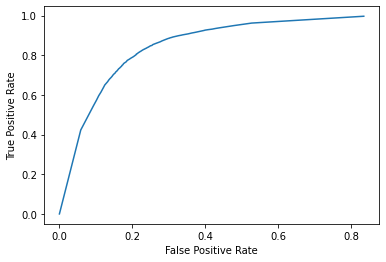

In [27]:
plt.plot(fpr_list, tpr_list)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [17]:
for th in range(len(thlist)):
    idx=th
    thresh=thlist[th]
    avg_recall0=np.mean(np.array(recall0list[idx]))
    std_recall0=np.std(np.array(recall0list[idx]))
    
    avg_recall1=np.mean(np.array(recall1list[idx]))
    std_recall1=np.std(np.array(recall1list[idx]))
    
    avg_precision0=np.mean(np.array(precision0list[idx]))
    std_precision0=np.std(np.array(precision0list[idx]))
    
    avg_precision1=np.mean(np.array(precision1list[idx]))
    std_precision1=np.std(np.array(precision1list[idx]))
    
    avg_acc=np.mean(np.array(acclist[idx]))
    std_acc=np.std(np.array(acclist[idx]))
    
    avg_bacc=np.mean(np.array(bacclist[idx]))
    std_bacc=np.std(np.array(bacclist[idx]))
    max_bacc=np.max(np.array(bacclist[idx]))
    min_bacc=np.min(np.array(bacclist[idx]))
    
    avg_hss=np.mean(np.array(hsslist[idx]))
    std_hss=np.std(np.array(hsslist[idx]))
    max_hss=np.max(np.array(hsslist[idx]))
    min_hss=np.min(np.array(hsslist[idx]))
    
    avg_tss=np.mean(np.array(tsslist[idx]))
    std_tss=np.std(np.array(tsslist[idx]))
    max_tss=np.max(np.array(tsslist[idx]))
    min_tss=np.min(np.array(tsslist[idx]))
    
    avg_recall0_list.append(round(avg_recall0, 3))
    std_recall0_list.append(round(std_recall0, 3))
    avg_precision0_list.append(round(avg_precision0, 3))
    std_precision0_list.append(round(std_precision0, 3))
    avg_acc_list.append(round(avg_acc, 3))
    std_acc_list.append(round(std_acc, 3))
    avg_bacc_list.append(round(avg_bacc, 3))
    std_bacc_list.append(round(std_bacc, 3))
    avg_hss_list.append(round(avg_hss, 3))
    std_hss_list.append(round(std_hss, 3))
    avg_tss_list.append(round(avg_tss, 3))
    std_tss_list.append(round(std_tss, 3))
    
    

In [18]:
max_avg_tss=0.0
max_avg_hss=0.0
max_avg_recall0=0.0
max_avg_tss_idx=-1

for idx in range(thlistsize):
    if avg_tss_list[idx]>max_avg_tss:
        max_avg_tss=avg_tss_list[idx]
        max_avg_hss=avg_hss_list[idx]
        max_avg_recall0=avg_recall0_list[idx]
        max_avg_tss_idx=idx
    elif avg_tss_list[idx]==max_avg_tss:
        if avg_hss_list[idx]>max_avg_hss:
            max_avg_tss=avg_tss_list[idx]
            max_avg_hss=avg_hss_list[idx]
            max_avg_recall0=avg_recall0_list[idx]
            max_avg_tss_idx=idx
        elif avg_hss_list[idx]==max_avg_hss:
            if avg_recall0_list[idx]>max_avg_recall0:
                max_avg_tss=avg_tss_list[idx]
                max_avg_hss=avg_hss_list[idx]
                max_avg_recall0=avg_recall0_list[idx]
                max_avg_tss_idx=idx

In [19]:
print ('threshold: ' +str(thlist[max_avg_tss_idx])+ '\n')

print('avg recall: '+str(avg_recall0_list[max_avg_tss_idx]) +
      ' (' + str(std_recall0_list[max_avg_tss_idx]) + ')\n')
print('avg precision: ' + str(avg_precision0_list[max_avg_tss_idx])
      +' (' + str(std_precision0_list[max_avg_tss_idx]) +')\n')
print('avg acc: ' + str(avg_acc_list[max_avg_tss_idx]) 
      + ' (' + str(std_acc_list[max_avg_tss_idx]) + ')\n')
print('avg bacc: ' +str(avg_bacc_list[max_avg_tss_idx]) + ' ('
      + str(std_bacc_list[max_avg_tss_idx]) + ')\n')
print('avg hss: ' + str(avg_hss_list[max_avg_tss_idx]) 
      + ' (' +str(std_hss_list[max_avg_tss_idx]) +')\n')
print('avg tss: ' + str(avg_tss_list[max_avg_tss_idx])+' ('
      +str(std_tss_list[max_avg_tss_idx])+ ')\n')



threshold: 0.44

avg recall: 0.744 (0.012)

avg precision: 0.52 (0.017)

avg acc: 0.815 (0.009)

avg bacc: 0.788 (0.006)

avg hss: 0.496 (0.017)

avg tss: 0.577 (0.012)



Results for 10 iterations (40epochs) WITH Drop WITH activ.reg.

In [89]:
print ('threshold: ' +str(thlist[max_avg_tss_idx])+ '\n')

print('avg recall: '+str(avg_recall0_list[max_avg_tss_idx]) +
      ' (' + str(std_recall0_list[max_avg_tss_idx]) + ')\n')
print('avg precision: ' + str(avg_precision0_list[max_avg_tss_idx])
      +' (' + str(std_precision0_list[max_avg_tss_idx]) +')\n')
print('avg acc: ' + str(avg_acc_list[max_avg_tss_idx]) 
      + ' (' + str(std_acc_list[max_avg_tss_idx]) + ')\n')
print('avg bacc: ' +str(avg_bacc_list[max_avg_tss_idx]) + ' ('
      + str(std_bacc_list[max_avg_tss_idx]) + ')\n')
print('avg hss: ' + str(avg_hss_list[max_avg_tss_idx]) 
      + ' (' +str(std_hss_list[max_avg_tss_idx]) +')\n')
print('avg tss: ' + str(avg_tss_list[max_avg_tss_idx])+' ('
      +str(std_tss_list[max_avg_tss_idx])+ ')\n')



threshold: 0.6

avg recall: 0.728 (0.015)

avg precision: 0.564 (0.017)

avg acc: 0.837 (0.007)

avg bacc: 0.796 (0.003)

avg hss: 0.533 (0.011)

avg tss: 0.592 (0.006)



Results for 10 iterations(25 epochs) WITH drop. WITH activity regul.

In [45]:
print ('threshold: ' +str(thlist[max_avg_tss_idx])+ '\n')

print('avg recall: '+str(avg_recall0_list[max_avg_tss_idx]) +
      ' (' + str(std_recall0_list[max_avg_tss_idx]) + ')\n')
print('avg precision: ' + str(avg_precision0_list[max_avg_tss_idx])
      +' (' + str(std_precision0_list[max_avg_tss_idx]) +')\n')
print('avg acc: ' + str(avg_acc_list[max_avg_tss_idx]) 
      + ' (' + str(std_acc_list[max_avg_tss_idx]) + ')\n')
print('avg bacc: ' +str(avg_bacc_list[max_avg_tss_idx]) + ' ('
      + str(std_bacc_list[max_avg_tss_idx]) + ')\n')
print('avg hss: ' + str(avg_hss_list[max_avg_tss_idx]) 
      + ' (' +str(std_hss_list[max_avg_tss_idx]) +')\n')
print('avg tss: ' + str(avg_tss_list[max_avg_tss_idx])+' ('
      +str(std_tss_list[max_avg_tss_idx])+ ')\n')



threshold: 0.5

avg recall: 0.737 (0.009)

avg precision: 0.539 (0.012)

avg acc: 0.825 (0.006)

avg bacc: 0.792 (0.003)

avg hss: 0.512 (0.01)

avg tss: 0.584 (0.005)



 Results for 10 iterations(14 epochs) WITH dorop WITH activty regul.

In [31]:
print('avg recall: '+str(avg_recall0_list[max_avg_tss_idx]) +
      ' (' + str(std_recall0_list[max_avg_tss_idx]) + ')\n')
print('avg precision: ' + str(avg_precision0_list[max_avg_tss_idx])
      +' (' + str(std_precision0_list[max_avg_tss_idx]) +')\n')
print('avg acc: ' + str(avg_acc_list[max_avg_tss_idx]) 
      + ' (' + str(std_acc_list[max_avg_tss_idx]) + ')\n')
print('avg bacc: ' +str(avg_bacc_list[max_avg_tss_idx]) + ' ('
      + str(std_bacc_list[max_avg_tss_idx]) + ')\n')
print('avg hss: ' + str(avg_hss_list[max_avg_tss_idx]) 
      + ' (' +str(std_hss_list[max_avg_tss_idx]) +')\n')
print('avg tss: ' + str(avg_tss_list[max_avg_tss_idx])+' ('
      +str(std_tss_list[max_avg_tss_idx])+ ')\n')

avg recall: 0.734 (0.021)

avg precision: 0.523 (0.022)

avg acc: 0.817 (0.011)

avg bacc: 0.785 (0.002)

avg hss: 0.495 (0.015)

avg tss: 0.571 (0.005)



Results for 10 ieration(7 epochs) WITH dropout WITH activity regularization

In [20]:
print('avg recall: '+str(avg_recall0_list[max_avg_tss_idx]) +
      ' (' + str(std_recall0_list[max_avg_tss_idx]) + ')\n')
print('avg precision: ' + str(avg_precision0_list[max_avg_tss_idx])
      +' (' + str(std_precision0_list[max_avg_tss_idx]) +')\n')
print('avg acc: ' + str(avg_acc_list[max_avg_tss_idx]) 
      + ' (' + str(std_acc_list[max_avg_tss_idx]) + ')\n')
print('avg bacc: ' +str(avg_bacc_list[max_avg_tss_idx]) + ' ('
      + str(std_bacc_list[max_avg_tss_idx]) + ')\n')
print('avg hss: ' + str(avg_hss_list[max_avg_tss_idx]) 
      + ' (' +str(std_hss_list[max_avg_tss_idx]) +')\n')
print('avg tss: ' + str(avg_tss_list[max_avg_tss_idx])+' ('
      +str(std_tss_list[max_avg_tss_idx])+ ')\n')

avg recall: 0.7 (0.016)

avg precision: 0.507 (0.012)

avg acc: 0.808 (0.007)

avg bacc: 0.767 (0.006)

avg hss: 0.467 (0.012)

avg tss: 0.535 (0.013)



In [50]:
print('avg recall: '+str(avg_recall0_list[max_avg_tss_idx]) +
      ' (' + str(std_recall0_list[max_avg_tss_idx]) + ')\n')
print('avg precision: ' + str(avg_precision0_list[max_avg_tss_idx])
      +' (' + str(std_precision0_list[max_avg_tss_idx]) +')\n')
print('avg acc: ' + str(avg_acc_list[max_avg_tss_idx]) 
      + ' (' + str(std_acc_list[max_avg_tss_idx]) + ')\n')
print('avg bacc: ' +str(avg_bacc_list[max_avg_tss_idx]) + ' ('
      + str(std_bacc_list[max_avg_tss_idx]) + ')\n')
print('avg hss: ' + str(avg_hss_list[max_avg_tss_idx]) 
      + ' (' +str(std_hss_list[max_avg_tss_idx]) +')\n')
print('avg tss: ' + str(avg_tss_list[max_avg_tss_idx])+' ('
      +str(std_tss_list[max_avg_tss_idx])+ ')\n')

avg recall: 0.706 (0.014)

avg precision: 0.494 (0.016)

avg acc: 0.801 (0.009)

avg bacc: 0.765 (0.005)

avg hss: 0.455 (0.014)

avg tss: 0.53 (0.01)



Results for 10 iterations(7 epochs ) WITH dopout WHIOUT activity regularization

In [50]:
print('avg recall: '+str(avg_recall0_list[max_avg_tss_idx]) +
      ' (' + str(std_recall0_list[max_avg_tss_idx]) + ')\n')
print('avg precision: ' + str(avg_precision0_list[max_avg_tss_idx])
      +' (' + str(std_precision0_list[max_avg_tss_idx]) +')\n')
print('avg acc: ' + str(avg_acc_list[max_avg_tss_idx]) 
      + ' (' + str(std_acc_list[max_avg_tss_idx]) + ')\n')
print('avg bacc: ' +str(avg_bacc_list[max_avg_tss_idx]) + ' ('
      + str(std_bacc_list[max_avg_tss_idx]) + ')\n')
print('avg hss: ' + str(avg_hss_list[max_avg_tss_idx]) 
      + ' (' +str(std_hss_list[max_avg_tss_idx]) +')\n')
print('avg tss: ' + str(avg_tss_list[max_avg_tss_idx])+' ('
      +str(std_tss_list[max_avg_tss_idx])+ ')\n')

avg recall: 0.706 (0.014)

avg precision: 0.494 (0.016)

avg acc: 0.801 (0.009)

avg bacc: 0.765 (0.005)

avg hss: 0.455 (0.014)

avg tss: 0.53 (0.01)



 Results for 10 iterations (7 epochs) without activity regularizations without dropout

In [37]:
print('avg recall: '+str(avg_recall0_list[max_avg_tss_idx]) +
      ' (' + str(std_recall0_list[max_avg_tss_idx]) + ')\n')
print('avg precision: ' + str(avg_precision0_list[max_avg_tss_idx])
      +' (' + str(std_precision0_list[max_avg_tss_idx]) +')\n')
print('avg acc: ' + str(avg_acc_list[max_avg_tss_idx]) 
      + ' (' + str(std_acc_list[max_avg_tss_idx]) + ')\n')
print('avg bacc: ' +str(avg_bacc_list[max_avg_tss_idx]) + ' ('
      + str(std_bacc_list[max_avg_tss_idx]) + ')\n')
print('avg hss: ' + str(avg_hss_list[max_avg_tss_idx]) 
      + ' (' +str(std_hss_list[max_avg_tss_idx]) +')\n')
print('avg tss: ' + str(avg_tss_list[max_avg_tss_idx])+' ('
      +str(std_tss_list[max_avg_tss_idx])+ ')\n')

avg recall: 0.713 (0.019)

avg precision: 0.493 (0.015)

avg acc: 0.8 (0.008)

avg bacc: 0.767 (0.005)

avg hss: 0.457 (0.011)

avg tss: 0.535 (0.009)



 results for 100 iterations (7 epochs) without activity regular, without dropout

In [40]:
f=open("./output.txt", "w")
f.write('results for 100 iterations (7 epochs) without activity regular, without dropout\n')
f.write('\n')
f.write('thresh = '+str(thlist[max_avg_tss_idx])+ '\n')

15

In [30]:

print('avg recall: '+str(avg_recall0_list[max_avg_tss_idx]) +
      ' (' + str(std_recall0_list[max_avg_tss_idx]) + ')\n')
print('avg precision: ' + str(avg_precision0_list[max_avg_tss_idx])
      +' (' + str(std_precision0_list[max_avg_tss_idx]) +')\n')
print('avg acc: ' + str(avg_acc_list[max_avg_tss_idx]) 
      + ' (' + str(std_acc_list[max_avg_tss_idx]) + ')\n')
print('avg bacc: ' +str(avg_bacc_list[max_avg_tss_idx]) + ' ('
      + str(std_bacc_list[max_avg_tss_idx]) + ')\n')
print('avg hss: ' + str(avg_hss_list[max_avg_tss_idx]) 
      + ' (' +str(std_hss_list[max_avg_tss_idx]) +')\n')
print('avg tss: ' + str(avg_tss_list[max_avg_tss_idx])+' ('
      +str(std_tss_list[max_avg_tss_idx])+ ')\n')

avg recall: 0.709 (0.017)

avg precision: 0.501 (0.021)

avg acc: 0.804 (0.011)

avg bacc: 0.768 (0.006)

avg hss: 0.464 (0.018)

avg tss: 0.537 (0.011)



In [55]:
df=pd.read_csv('./C/normalized_training.csv')

In [56]:
df

,label,flare,timestamp,NOAA,HARP,TOTUSJH,Cdec,TOTUSJZ,Chis1d,USFLUX,...,Bhis1d,Bhis,Mhis1d,EPSZ,MEANGBH,MEANJZH,MEANALP,Xhis,Xdec,Xhis1d
0,Negative,N,2010-05-03T05:34:22.60Z,11063,11,-0.567834,0.000000,-0.125322,0.0,-0.712481,...,0.0,0.000000,0.000000,0.535443,0.716336,1.364450,-0.623816,0.0,0.0,0.0
1,Negative,N,2010-05-03T06:34:22.60Z,11063,11,-0.571116,0.000000,-0.195688,0.0,-0.714876,...,0.0,0.000000,0.000000,-0.168495,1.065008,0.786958,-0.619474,0.0,0.0,0.0
2,Negative,N,2010-05-03T07:34:22.60Z,11063,11,-0.559336,0.000000,-0.160199,0.0,-0.714202,...,0.0,0.000000,0.000000,-0.301990,1.212839,0.362941,-0.617128,0.0,0.0,0.0
3,Negative,N,2010-05-03T08:34:22.60Z,11063,11,-0.584086,0.000000,-0.256048,0.0,-0.713703,...,0.0,0.000000,0.000000,-0.296428,1.261323,0.067030,-0.610767,0.0,0.0,0.0
4,Negative,N,2010-05-03T09:34:22.60Z,11063,11,-0.574319,0.000000,-0.275039,0.0,-0.710402,...,0.0,0.000000,0.000000,-0.164787,1.369495,-0.025539,-0.609721,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127704,Positive,C2.5,2014-01-02T15:46:09.10Z,11936,3535,3.006697,0.005185,0.422409,0.0,2.307591,...,0.0,0.037736,0.090909,-1.110994,-0.308918,0.133939,2.849963,0.0,0.0,0.0
127705,Positive,C2.5,2014-01-02T16:46:09.10Z,11936,3535,2.975592,0.004770,0.804194,0.0,2.339006,...,0.0,0.037736,0.090909,-1.148076,-0.376186,0.162697,2.892229,0.0,0.0,0.0
127706,Positive,C2.5,2014-01-02T17:46:09.10Z,11936,3535,3.113931,0.004389,0.653550,0.0,2.331007,...,0.0,0.037736,0.090909,-1.268592,-0.427330,0.074292,2.902795,0.0,0.0,0.0
127707,Positive,C2.5,2014-01-02T18:46:09.10Z,11936,3535,3.000728,0.004038,0.318120,0.0,2.369386,...,0.0,0.037736,0.000000,-1.288987,-0.529957,0.072162,2.857465,0.0,0.0,0.0
